In [37]:
# 0. Load libraries #

import numpy as np
import pandas as pd
import os, time, warnings, random, gc, pickle, optuna
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.svm import SVC
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier

pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.expand_frame_repr', False)
warnings.filterwarnings('ignore')

# Load custom pre-processing functions:

def draw_histograms(df, variables, n_rows, n_cols):
    # stolen from https://stackoverflow.com/questions/29530355/plotting-multiple-histograms-in-grid
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name+" Distribution")
    fig.tight_layout()  
    plt.show()


def fillna_mp_i1(df_train, df_test, df_pred, num_features, cat_features, num_fill='median', cat_fill='mode'):
    """This function speeds up filling missing values for 3 main datasets using different imputation methods.
    Later may replace it with some subclass.
    Example: fillna_mp_i1(X_train, X_test, X_pred, num_cols, cat_cols)"""
    # set df_pred to None if it does not exist
    if not ((cat_fill=='mode') and (num_fill=='median')):
        print ('Imputation method not Implemented yet!')
        return None
    
    df_train[num_features] = df_train[num_features].fillna(value=df_train[num_features].median())
    df_test[num_features] = df_test[num_features].fillna(value=df_train[num_features].median())
    df_train[cat_features] = df_train[cat_features].fillna(value=df_train[cat_features].mode().iloc[0])
    df_test[cat_features] = df_test[cat_features].fillna(value=df_train[cat_features].mode().iloc[0])
    if (df_pred is not None):
        df_pred[num_features] = df_pred[num_features].fillna(value=df_train[num_features].median())
        df_pred[cat_features] = df_pred[cat_features].fillna(value=df_train[cat_features].mode().iloc[0])
    df_train[num_features+cat_features].count
    
    all_good = (
    (np.prod(df_train[num_features+cat_features].shape)==df_train[num_features+cat_features].count().sum()) and 
    (np.prod(df_test[num_features+cat_features].shape) == df_test[num_features+cat_features].count().sum()) and 
    (np.prod(df_pred[num_features+cat_features].shape) == df_pred[num_features+cat_features].count().sum()))
    if (all_good):
        print('Missing values imputed successfully')
    else:
        print('There are still some missing values...')
    
def add_misDummy_mp_i1(df_train, df_test, df_pred, features):
    """This function creates new dummy columns for missing features.
    Example: add_misDummy_mp_i1(X_train, X_test, X_pred, ['Age'])"""
    # set df_pred to None if it does not exist
    for feature_name in features:
        misColName = 'mis'+feature_name
        df_train.loc[df_train[feature_name].isnull(), misColName]=1
        df_train.loc[df_train[feature_name].notnull(), misColName]=0
        df_test.loc[df_test[feature_name].isnull(), misColName]=1
        df_test.loc[df_test[feature_name].notnull(), misColName]=0
        if (df_pred is not None):
            df_pred.loc[df_pred[feature_name].isnull(), misColName]=1
            df_pred.loc[df_pred[feature_name].notnull(), misColName]=0
   

def discretize_mp_i1(df_train, df_test, df_pred, feature, ntiles, delete_feature=False):
    """This function divides a continuous feature into quantile groups.
    Example: discretize_mp_i1(X_train, X_test, X_pred, 'Age', 15)"""
    # set df_pred to None if it does not exist
    _,bin = pd.qcut(df_train[feature], ntiles, retbins = True, labels = False, duplicates = 'drop')
    df_train[feature+'Ntile'] = pd.cut(df_train[feature], labels=False, duplicates = 'drop', bins = bin ,include_lowest = True)
    df_test[feature+'Ntile'] = pd.cut(df_test[feature], labels=False, duplicates = 'drop', bins = bin ,include_lowest = True)
    if (df_pred is not None):
        df_pred[feature+'Ntile'] = pd.cut(df_pred[feature], labels=False, duplicates = 'drop', bins = bin ,include_lowest = True)
    if (delete_feature==True):
        df_train.drop(columns=[feature], inplace=True)
        df_test.drop(columns=[feature], inplace=True)
        df_pred.drop(columns=[feature], inplace=True)
    print('Discretized ',feature, ' into ', len(bin)-1, ' bins')


def log_transformer_mp_i1(df_train, df_test, df_pred, feature_subset=False, min_skew=3):
    """This function divides a continuous feature into quantile groups.
    Example: log_transformer_mp_i1(X_train, X_test, X_pred, feature_subset=num_cols)"""
    # set df_pred to None if it does not exist
    if (feature_subset==False):
        features_totransform = df_train.columns
    else:
        features_totransform = feature_subset.copy()
    skewed_vars = list(df_train.skew()[abs(df_train.skew())>min_skew].index)
    for col in list(set(skewed_vars)&set(features_totransform)):
        df_train[col] = np.log1p(df_train[col])
        df_test[col] = np.log1p(df_test[col])
        if (df_pred is not None):
            df_pred[col] = np.log1p(df_pred[col])
    print('Skewed columns log-transformed: ', list(set(skewed_vars)&set(features_totransform)))
    
    


In [38]:
time0 = time.time()
with open('../input/amex-default-downsampled-01/amex_default_0.1sample.pickle', 'rb') as pickled_one:
    df = pickle.load(pickled_one)
display(df.head(),df.shape)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,2017-05-30,0.937438,0.003936,0.003352,0.814304,0.002594,NaN,0.000545,0.003142,NaN,0.051788,0.006299,0.056203,0.294726,0.006012,0.004684,0.516281,0.463092,0.263574,NaN,0.048533,0.042849,0.006816,0.076369,0.004431,0.006775,0.005824,0.192826,0.577143,0.044728,NaN,0.003280,0.007864,1.000973,1.008453,0.000671,NaN,0.139550,0.003945,0.177336,0.169218,0.008859,0.009552,0.331046,NaN,0.005952,0.292875,0.002996,0.174586,0.005551,0.288992,0.081457,CO,O,0.009775,0.008577,NaN,0.645052,0.001056,1.0,0.001964,6.0,0.193990,0.000306,0.001171,0.000274,0.006808,0.005755,0.259391,0.015849,0.001570,0.507748,0.025547,NaN,0.001370,0.150138,0.137811,NaN,0.009684,0.004231,NaN,0.005078,0.003550,0.003895,0.000551,0.008775,NaN,0.003207,0.004396,0.004527,0.008564,0.006419,0.007386,NaN,0.000966,1.009854,0.058119,0.003344,0.007251,0.003969,0.008143,0.005722,0.009559,NaN,0.0,0.004709,0.001287,NaN,0.006435,0.008478,NaN,1,0.005740,0.005207,0.005587,0.000917,0.002636,0.001219,1.008942,0.000116,0.002600,0.001327,0.005468,0.006224,0.000029,0.003084,0.000054,0.005109,0.002801,0.301518,0.140075,0.082386,0.977059,0.001901,0.413177,1.000086,0.958687,0.661508,NaN,1.003331,0.006081,0.009483,NaN,1.005789,2.0,NaN,0.000268,NaN,NaN,NaN,1.009410,0.165166,NaN,0.001087,1.0,0.425165,0.0,4.0,0.418822,0.419459,0.0,0.547555,0.438120,0.003239,0.187171,0.006194,1.0,0.009093,1.005538,1.000016,0.003450,NaN,1.005729,0.001219,NaN,0.002394,0.004556,NaN,NaN,NaN,NaN,NaN,0.008103,0.006132,0.003267,NaN,0.008814,0.001211,0.001624
1,00013181a0c5fc8f1ea38cd2b90fe8ad2fa8cad9d9f13e...,2017-06-16,0.471242,0.001547,0.000233,0.816437,0.003437,NaN,0.005852,0.005877,NaN,0.208440,0.382538,0.313276,0.054264,0.002035,0.002264,0.951780,0.325470,0.740619,NaN,0.007790,1.047744,1.005298,0.076422,0.000206,0.005905,0.009041,0.148017,0.493458,0.039864,NaN,0.006881,0.003204,1.005171,1.001148,0.007656,NaN,0.010886,0.007330,0.448186,0.126476,0.004810,0.003998,0.619877,NaN,0.003674,0.375356,0.001085,0.599261,0.004723,0.285493,0.017829,CO,O,0.001949,0.005428,NaN,0.532836,0.001264,NaN,0.002074,5.0,0.184956,0.004232,0.004607,0.000368,0.002620,0.003322,1.008265,0.034615,0.001517,0.500245,0.995367,NaN,0.001463,0.365847,0.338917,NaN,0.007694,0.004741,NaN,0.004701,0.009776,0.004254,0.001066,0.003238,0.171472,0.003671,0.409818,0.001820,0.001104,0.008046,0.001091,NaN,0.001583,1.004534,0.211125,0.002501,0.007636,0.009532,0.004129,0.001284,0.008175,NaN,0.0,0.003752,0.004509,NaN,0.001339,0.008494,NaN,1,0.005238,0.008327,0.002736,0.007807,0.005138,0.009324,1.006314,0.005657,0.006198,0.006972,0.007000,0.001464,0.001995,0.004677,0.009206,0.008958,0.008415,0.302657,0.134319,0.086714,0.972725,0.000080,0.003580,0.008142,0.003662,NaN,NaN,0.008267,0.000910,0.002263,0.081330,0.015774,1.0,NaN,0.005904,NaN,NaN,NaN,1.002032,1.113697,NaN,0.004361,1.0,0.044666,0.0,4.0,0.045775,0.044385,0.0,0.755079,0.291698,0.009170,0.455286,0.006972,1.0,0.008171,1.004957,1.009854,0.000533,NaN,1.002896,0.006603,NaN,0.007623,0.006064,NaN,NaN,NaN,NaN,NaN

(54849, 190)

In [39]:
df_labels = pd.read_csv('../input/amex-default-prediction/train_labels.csv')
display(len(df_labels))
df = pd.merge(df, df_labels, on='customer_ID', how='left')
display(df.shape, df.head())
df.drop(columns=['customer_ID', 'S_2'], inplace=True)

458913

(54849, 191)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,2017-05-30,0.937438,0.003936,0.003352,0.814304,0.002594,NaN,0.000545,0.003142,NaN,0.051788,0.006299,0.056203,0.294726,0.006012,0.004684,0.516281,0.463092,0.263574,NaN,0.048533,0.042849,0.006816,0.076369,0.004431,0.006775,0.005824,0.192826,0.577143,0.044728,NaN,0.003280,0.007864,1.000973,1.008453,0.000671,NaN,0.139550,0.003945,0.177336,0.169218,0.008859,0.009552,0.331046,NaN,0.005952,0.292875,0.002996,0.174586,0.005551,0.288992,0.081457,CO,O,0.009775,0.008577,NaN,0.645052,0.001056,1.0,0.001964,6.0,0.193990,0.000306,0.001171,0.000274,0.006808,0.005755,0.259391,0.015849,0.001570,0.507748,0.025547,NaN,0.001370,0.150138,0.137811,NaN,0.009684,0.004231,NaN,0.005078,0.003550,0.003895,0.000551,0.008775,NaN,0.003207,0.004396,0.004527,0.008564,0.006419,0.007386,NaN,0.000966,1.009854,0.058119,0.003344,0.007251,0.003969,0.008143,0.005722,0.009559,NaN,0.0,0.004709,0.001287,NaN,0.006435,0.008478,NaN,1,0.005740,0.005207,0.005587,0.000917,0.002636,0.001219,1.008942,0.000116,0.002600,0.001327,0.005468,0.006224,0.000029,0.003084,0.000054,0.005109,0.002801,0.301518,0.140075,0.082386,0.977059,0.001901,0.413177,1.000086,0.958687,0.661508,NaN,1.003331,0.006081,0.009483,NaN,1.005789,2.0,NaN,0.000268,NaN,NaN,NaN,1.009410,0.165166,NaN,0.001087,1.0,0.425165,0.0,4.0,0.418822,0.419459,0.0,0.547555,0.438120,0.003239,0.187171,0.006194,1.0,0.009093,1.005538,1.000016,0.003450,NaN,1.005729,0.001219,NaN,0.002394,0.004556,NaN,NaN,NaN,NaN,NaN,0.008103,0.006132,0.003267,NaN,0.008814,0.001211,0.001624,0
1,00013181a0c5fc8f1ea38cd2b90fe8ad2fa8cad9d9f13e...,2017-06-16,0.471242,0.001547,0.000233,0.816437,0.003437,NaN,0.005852,0.005877,NaN,0.208440,0.382538,0.313276,0.054264,0.002035,0.002264,0.951780,0.325470,0.740619,NaN,0.007790,1.047744,1.005298,0.076422,0.000206,0.005905,0.009041,0.148017,0.493458,0.039864,NaN,0.006881,0.003204,1.005171,1.001148,0.007656,NaN,0.010886,0.007330,0.448186,0.126476,0.004810,0.003998,0.619877,NaN,0.003674,0.375356,0.001085,0.599261,0.004723,0.285493,0.017829,CO,O,0.001949,0.005428,NaN,0.532836,0.001264,NaN,0.002074,5.0,0.184956,0.004232,0.004607,0.000368,0.002620,0.003322,1.008265,0.034615,0.001517,0.500245,0.995367,NaN,0.001463,0.365847,0.338917,NaN,0.007694,0.004741,NaN,0.004701,0.009776,0.004254,0.001066,0.003238,0.171472,0.003671,0.409818,0.001820,0.001104,0.008046,0.001091,NaN,0.001583,1.004534,0.211125,0.002501,0.007636,0.009532,0.004129,0.001284,0.008175,NaN,0.0,0.003752,0.004509,NaN,0.001339,0.008494,NaN,1,0.005238,0.008327,0.002736,0.007807,0.005138,0.009324,1.006314,0.005657,0.006198,0.006972,0.007000,0.001464,0.001995,0.004677,0.009206,0.008958,0.008415,0.302657,0.134319,0.086714,0.972725,0.000080,0.003580,0.008142,0.003662,NaN,NaN,0.008267,0.000910,0.002263,0.081330,0.015774,1.0,NaN,0.005904,NaN,NaN,NaN,1.002032,1.113697,NaN,0.004361,1.0,0.044666,0.0,4.0,0.045775,0.044385,0.0,0.755079,0.291698,0.009170,0.455286,0.006972,1.0,0.008171,1.004957,1.009854,0.000533,NaN,1.002896,0.006603,NaN,0.007623,0.006064,NaN,NaN,Na

In [40]:
miss_c = df.count()
miss_feat = miss_c[miss_c<40000]
df = df[list(set(df.columns)-set(miss_feat.index))]
display(df.shape)
df[['D_114','D_120','D_68','B_30','D_117','D_116','B_38']] = \
df[['D_114','D_120','D_68','B_30','D_117','D_116','B_38']].apply(pd.to_numeric)
df['D_64'] = df['D_64'].astype('string')
display(df.dtypes)

(54849, 157)

B_9       float64
S_18      float64
D_103     float64
D_131     float64
S_20      float64
D_121     float64
R_18      float64
S_3       float64
D_81      float64
R_2       float64
B_19      float64
P_3       float64
D_79      float64
D_63       object
D_55      float64
D_86      float64
D_52      float64
B_8       float64
R_8       float64
B_4       float64
R_3       float64
B_38      float64
B_6       float64
B_28      float64
D_48      float64
R_24      float64
B_23      float64
D_130     float64
D_62      float64
D_68      float64
D_70      float64
D_128     float64
R_25      float64
S_23      float64
D_83      float64
B_13      float64
B_12      float64
D_122     float64
B_11      float64
S_13      float64
B_15      float64
R_19      float64
D_89      float64
D_107     float64
D_109     float64
B_10      float64
S_11      float64
D_41      float64
D_59      float64
R_7       float64
R_21      float64
B_41      float64
D_104     float64
S_24      float64
D_124     float64
D_51      

In [41]:
### sample split ###

test_size = 0.1
df.reset_index(inplace=True, drop=True)
test_index = random.sample(list(df.index), int(test_size*df.shape[0]))
train = df.iloc[list(set(df.index)-set(test_index))]
test = df.iloc[test_index]
display(train.shape, test.shape, train.head(3), test.head(3))
display(train.dtypes, test.dtypes)


(49365, 157)

(5484, 157)

,B_9,S_18,D_103,D_131,S_20,D_121,R_18,S_3,D_81,R_2,B_19,P_3,D_79,D_63,D_55,D_86,D_52,B_8,R_8,B_4,R_3,B_38,B_6,B_28,D_48,R_24,B_23,D_130,D_62,D_68,D_70,D_128,R_25,S_23,D_83,B_13,B_12,D_122,B_11,S_13,B_15,R_19,D_89,D_107,D_109,B_10,S_11,D_41,D_59,R_7,R_21,B_41,D_104,S_24,D_124,D_51,D_75,R_14,D_54,D_143,D_112,R_10,B_24,D_119,R_22,B_20,P_2,B_26,S_19,S_27,R_5,S_22,B_37,R_27,B_36,D_114,S_5,S_25,S_16,D_96,S_12,R_1,B_25,D_118,R_15,B_5,D_116,D_145,B_16,B_22,B_27,D_65,D_115,D_94,D_60,D_125,D_64,S_15,D_144,B_30,R_12,D_141,D_61,R_16,S_17,D_93,D_39,D_133,B_40,S_6,R_13,D_91,D_117,D_80,D_127,B_18,D_123,R_4,B_21,B_33,D_120,R_20,D_129,D_47,B_7,R_17,D_84,D_140,D_139,B_14,target,D_113,D_45,R_6,B_3,B_32,B_2,B_31,D_78,D_69,S_7,D_74,R_11,D_126,D_92,R_23,D_72,P_4,B_1,S_8,D_46,D_102,D_44,D_71,S_26,R_28,D_58
0,0.006775,0.004709,1.000086,0.001219,0.000917,0.547555,0.008478,NaN,0.007386,0.004684,0.001056,0.577143,0.000551,CO,0.177336,0.001287,0.192826,0.006816,0.008775,0.056203,0.005824,2.0,0.048533,0.058119,0.263574,0.000054,0.025547,1.005729,0.081457,6.0,0.259391,1.005538,0.005109,0.140075,0.007251,0.008859,0.139550,0.438120,0.007864,0.001171,0.005551,0.005207,0.000116,1.003331,0.000268,0.044728,0.288992,0.000545,0.292875,0.004231,0.001219,0.003450,0.958687,0.082386,0.187171,0.004431,0.137811,0.003969,1.008453,0.008814,1.009410,0.004527,0.009684,0.419459,0.002600,0.001964,0.937438,0.003550,0.005740,NaN,0.009552,0.301518,0.009483,1.005789,0.006081,1.0,0.003280,0.977059,0.003207,0.002801,0.193990,0.002594,0.005078,0.418822,0.008143,0.006012,0.0,0.001624,0.008577,0.005755,0.006419,0.009775,0.425165,0.003084,0.002996,0.006194,O,0.507748,0.001211,0.0,1.009854,0.003267,0.174586,0.009559,0.000966,0.000029,0.003936,0.002394,0.165166,1.000973,0.003344,0.005468,4.0,0.004396,0.009093,0.645052,0.003239,0.000671,0.000274,1.008942,0.0,0.002636,1.000016,0.463092,0.042849,0.006435,0.005722,0.006132,0.008103,0.005952,0,0.001087,0.294726,0.000306,0.003142,0.005587,0.814304,1,0.003895,0.006808,NaN,0.150138,0.008564,1.0,0.006224,0.001327,0.001570,0.001370,0.003352,0.003945,0.516281,0.413177,0.006299,0.015849,0.001901,0.004556,0.331046
1,0.005905,0.003752,0.008142,0.006603,0.007807,0.755079,0.008494,NaN,0.001091,0.002264,0.001264,0.493458,0.001066,CO,0.448186,0.004509,0.148017,1.005298,0.003238,0.313276,0.009041,1.0,0.007790,0.211125,0.740619,0.009206,0.995367,1.002896,0.017829,5.0,1.008265,1.004957,0.008958,0.134319,0.007636,0.004810,0.010886,0.291698,0.003204,0.004607,0.004723,0.008327,0.005657,0.008267,0.005904,0.039864,0.285493,0.005852,0.375356,0.004741,0.009324,0.000533,0.003662,0.086714,0.455286,0.000206,0.338917,0.009532,1.001148,0.006323,1.002032,0.001820,0.007694,0.044385,0.006198,0.002074,0.471242,0.009776,0.005238,NaN,0.003998,0.302657,0.002263,0.015774,0.000910,1.0,0.006881,0.972725,0.003671,0.008415,0.184956,0.003437,0.004701,0.045775,0.004129,0.002035,0.0,0.007420,0.005428,0.003322,0.008046,0.001949,0.044666,0.004677,0.001085,0.006972,O,0.500245,0.007118,0.0,1.004534,0.003350,0.599261,0.008175,0.001583,0.001995,0.001547,0.007623,1.113697,1.005171,0.002501,0.007000,4.0,0.409818,0.008171,0.532836,0.009170,0.007656,0.000368,1.006314,0.0,0.005138,1.009854,0.325470,1.047744,0.001339,0.001284,0.005849,0.009825,0.003674,1,0.004361,0.054264,0.004232,0.005877,0.002736,0.816437,1,0.004254,0.002620,NaN,0.365847,0.001104,1.0,0.001464,0.006972,0.001517,0.001463,0.000233,0.007330,0.951780,0.003580,0.382538,0.034615,0.000080,0.006064,0.619877
2,0.006622,0.007397,0.009385,0.007124,0.004779,0.760963,0.009613,NaN,0.004215,0.005044,0.006855,0.503620,0.008106,CO,0.622740,0.000639,0.149677,1.001536,0.003236,0.480630,0.108383,1.0,0.010100,0.317591,0.901241,0.007752,1.150840,1.002708,0.035034,5.0,0.257676,1.006152,0.005430,0.137537,0.006911,0.008290,0.007096,0.286112,0.006402,0.009873,0.002106,0.008371,0.001587,0.001168,0.008882,0.018164,0.289433,0.008037,0.425143,0.008762,0.006826,0.002559,0.003309,0.078743,0.460282,0.003159,0.340423,0.003373,1.002968,0.004756,1.004104,0.007499,

,B_9,S_18,D_103,D_131,S_20,D_121,R_18,S_3,D_81,R_2,B_19,P_3,D_79,D_63,D_55,D_86,D_52,B_8,R_8,B_4,R_3,B_38,B_6,B_28,D_48,R_24,B_23,D_130,D_62,D_68,D_70,D_128,R_25,S_23,D_83,B_13,B_12,D_122,B_11,S_13,B_15,R_19,D_89,D_107,D_109,B_10,S_11,D_41,D_59,R_7,R_21,B_41,D_104,S_24,D_124,D_51,D_75,R_14,D_54,D_143,D_112,R_10,B_24,D_119,R_22,B_20,P_2,B_26,S_19,S_27,R_5,S_22,B_37,R_27,B_36,D_114,S_5,S_25,S_16,D_96,S_12,R_1,B_25,D_118,R_15,B_5,D_116,D_145,B_16,B_22,B_27,D_65,D_115,D_94,D_60,D_125,D_64,S_15,D_144,B_30,R_12,D_141,D_61,R_16,S_17,D_93,D_39,D_133,B_40,S_6,R_13,D_91,D_117,D_80,D_127,B_18,D_123,R_4,B_21,B_33,D_120,R_20,D_129,D_47,B_7,R_17,D_84,D_140,D_139,B_14,target,D_113,D_45,R_6,B_3,B_32,B_2,B_31,D_78,D_69,S_7,D_74,R_11,D_126,D_92,R_23,D_72,P_4,B_1,S_8,D_46,D_102,D_44,D_71,S_26,R_28,D_58
29714,0.334203,0.008820,0.001789,0.002361,0.005893,0.635789,0.005654,0.636175,0.005327,0.004210,0.007262,0.241131,0.003571,CO,0.003372,0.000909,0.152680,1.009688,0.002687,0.002527,0.107663,2.0,0.200331,0.010026,NaN,0.002766,0.005189,0.000745,0.227732,6.0,0.001429,1.005132,0.000426,0.132939,0.005453,0.451907,0.405656,0.723103,0.001838,0.008147,0.006376,0.001557,0.002121,0.005724,0.001917,0.296367,0.163018,0.007616,0.258009,0.005906,0.004224,0.003294,0.005398,0.798247,0.552758,0.007154,0.009684,0.008731,1.001048,0.003809,1.000428,0.007930,0.009405,0.258312,0.008205,0.008622,0.714206,0.009946,0.009121,0.006504,0.002448,0.801978,0.000396,1.008490,0.000026,1.0,0.011922,0.969835,0.001965,0.009716,0.191050,0.000502,0.006706,0.263419,0.000701,0.020749,0.0,0.004891,0.003511,0.002451,0.002894,0.000676,0.269724,0.000908,0.886667,0.005015,O,0.208243,0.008151,0.0,1.007679,0.007120,NaN,0.006409,0.007970,0.004925,0.030127,0.004524,0.005799,0.005521,0.007167,0.000621,3.0,0.000441,0.003045,1.001933,0.000542,0.002087,0.007567,1.004102,0.0,0.009321,1.004026,0.287744,0.007355,0.004744,0.006559,0.000396,0.007453,0.012161,0,0.007912,0.019115,0.000629,0.007768,0.008977,1.000661,1,0.004858,0.000451,0.478283,0.002582,0.006075,1.0,0.008055,0.006237,0.000854,1.012902,0.002416,0.323266,NaN,0.003399,0.007315,0.013016,0.014181,0.000354,0.005178
13134,0.003505,0.004835,1.005443,0.007100,0.002265,0.293185,0.007231,0.987855,0.003522,0.005047,0.081347,0.497106,0.008343,CR,0.686035,0.001042,0.080216,0.001569,0.005616,0.162025,0.004302,5.0,0.020933,0.129274,0.590078,0.007136,0.220029,0.005435,0.036822,6.0,0.251629,0.008066,0.001068,0.132089,0.002645,0.027649,0.025693,0.148893,0.184831,0.004579,0.119040,0.003295,0.007823,0.671032,0.005289,0.027335,0.202720,0.009315,0.483997,0.006873,0.001135,0.006215,0.964586,0.973844,0.273226,0.001032,0.343183,0.008664,1.007490,0.004371,1.008289,0.003884,0.008052,0.059724,0.002926,0.592653,0.500740,0.006643,0.005371,0.006553,0.006745,0.951048,0.211068,1.004006,0.006085,0.0,0.258235,0.972087,0.009232,0.000174,0.189822,0.007915,0.003584,0.062796,0.006016,0.036848,0.0,0.007031,0.837385,0.509127,0.002629,0.006382,0.243084,0.005043,0.360010,0.009020,U,1.001705,0.000353,0.0,1.004916,0.009125,0.437645,0.001670,0.006083,0.009960,0.765698,0.007022,0.264662,0.004267,0.005555,0.006893,-1.0,0.000304,0.008894,0.201004,0.003141,0.002347,0.008572,0.008321,0.0,0.000296,0.000919,0.175137,0.257582,0.004333,0.003603,0.009337,0.002280,0.100996,1,0.201369,0.140076,0.005472,0.504010,0.007390,0.101274,1,0.003557,0.007492,0.813334,0.292856,0.003520,-1.0,0.007576,0.005405,0.008227,0.009873,0.214483,0.007092,0.520933,0.245637,0.128035,0.022823,0.009504,0.009709,0.442848
45133,0.605039,0.000406,1.000650,0.006334,0.006746,0.297387,0.004319,0.532840,0.001928,0.002161,0.008356,0.032296,0.009997,CO,0.469287,0.006138,0.093667,1.002261,0.006110,0.211835,0.104412,4.0,0.021742,0.246935,0.612523,0.009625,0.923487,0.005842,0.049957,1.0,0.009392,0.007142,0.001146,0.735710,0.006920,0.018064,0.009920,0.145214,0.070194,0.007700,0.002772,0.008158,0.005253,0.337186,0.002883,0.008836,0.446469,0.371877,0.447294,0.004065,0.007622,0.005271,0.967056,0.974929,0.459608,0.003446,0.338326,0.007782,1.

B_9       float64
S_18      float64
D_103     float64
D_131     float64
S_20      float64
D_121     float64
R_18      float64
S_3       float64
D_81      float64
R_2       float64
B_19      float64
P_3       float64
D_79      float64
D_63       object
D_55      float64
D_86      float64
D_52      float64
B_8       float64
R_8       float64
B_4       float64
R_3       float64
B_38      float64
B_6       float64
B_28      float64
D_48      float64
R_24      float64
B_23      float64
D_130     float64
D_62      float64
D_68      float64
D_70      float64
D_128     float64
R_25      float64
S_23      float64
D_83      float64
B_13      float64
B_12      float64
D_122     float64
B_11      float64
S_13      float64
B_15      float64
R_19      float64
D_89      float64
D_107     float64
D_109     float64
B_10      float64
S_11      float64
D_41      float64
D_59      float64
R_7       float64
R_21      float64
B_41      float64
D_104     float64
S_24      float64
D_124     float64
D_51      

B_9       float64
S_18      float64
D_103     float64
D_131     float64
S_20      float64
D_121     float64
R_18      float64
S_3       float64
D_81      float64
R_2       float64
B_19      float64
P_3       float64
D_79      float64
D_63       object
D_55      float64
D_86      float64
D_52      float64
B_8       float64
R_8       float64
B_4       float64
R_3       float64
B_38      float64
B_6       float64
B_28      float64
D_48      float64
R_24      float64
B_23      float64
D_130     float64
D_62      float64
D_68      float64
D_70      float64
D_128     float64
R_25      float64
S_23      float64
D_83      float64
B_13      float64
B_12      float64
D_122     float64
B_11      float64
S_13      float64
B_15      float64
R_19      float64
D_89      float64
D_107     float64
D_109     float64
B_10      float64
S_11      float64
D_41      float64
D_59      float64
R_7       float64
R_21      float64
B_41      float64
D_104     float64
S_24      float64
D_124     float64
D_51      

In [42]:
cat_feat = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_68']
num_feat = list(set(train.columns)-set(cat_feat)-set(['target']))
display(train[cat_feat], [train[col].value_counts() for col in train.columns if col in cat_feat])

,B_30,B_38,D_114,D_116,D_117,D_120,D_126,D_63,D_64,D_68
0,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CO,O,6.0
1,0.0,1.0,1.0,0.0,4.0,0.0,1.0,CO,O,5.0
2,0.0,1.0,1.0,0.0,4.0,0.0,1.0,CO,O,5.0
3,0.0,1.0,1.0,0.0,4.0,0.0,1.0,CO,O,6.0
4,1.0,6.0,0.0,0.0,-1.0,0.0,1.0,CO,U,3.0
...,...,...,...,...,...,...,...,...,...,...
54844,0.0,2.0,1.0,0.0,4.0,1.0,1.0,CR,O,5.0
54845,0.0,3.0,1.0,0.0,-1.0,0.0,1.0,CO,U,5.0
54846,0.0,2.0,1.0,0.0,5.0,0.0,1.0,CL,O,5.0
54847,0.0,1.0,NaN,NaN,NaN,NaN,NaN,CO,<NA>,NaN


[CO    36867
 CR     8244
 CL     3910
 XZ      201
 XM       85
 XL       58
 Name: D_63, dtype: int64,
 2.0    17272
 3.0    11325
 1.0    10345
 5.0     3940
 4.0     2627
 7.0     2317
 6.0     1521
 Name: B_38, dtype: int64,
 6.0    24775
 5.0    10708
 3.0     4362
 4.0     4218
 2.0     1967
 1.0     1239
 0.0      143
 Name: D_68, dtype: int64,
 1.0    29418
 0.0    18351
 Name: D_114, dtype: int64,
 0.0    47703
 1.0       66
 Name: D_116, dtype: int64,
 O     25790
 U     13688
 R      7593
 -1      344
 Name: D_64, dtype: Int64,
 0.0    42002
 1.0     6886
 2.0      459
 Name: B_30, dtype: int64,
 -1.0    13003
  3.0    10523
  4.0    10125
  2.0     5872
  5.0     4018
  6.0     3099
  1.0     1129
 Name: D_117, dtype: int64,
 0.0    42167
 1.0     5602
 Name: D_120, dtype: int64,
  1.0    37944
  0.0     8109
 -1.0     2257
 Name: D_126, dtype: int64]

In [43]:
for col in cat_feat:
    if train[col].dtype in ['string', 'O', 'str']:
        print('str', col)
    else:
        print('num', col)
        

num B_30
num B_38
num D_114
num D_116
num D_117
num D_120
num D_126
str D_63
str D_64
num D_68


In [44]:
### fill missing values ###

for col in cat_feat:
    if train[col].dtype in ['string', 'O', 'str']:
        train[col].fillna(value='M', inplace=True)
        test[col].fillna(value='M', inplace=True)
    else:
        train[col].fillna(value=-1000, inplace=True)
        test[col].fillna(value=-1000, inplace=True)

for col in num_feat:
    train[col].fillna(train[col].median(), inplace=True)
    test[col].fillna(train[col].median(), inplace=True)
    
display(train.count(), test.count())

B_9       49365
S_18      49365
D_103     49365
D_131     49365
S_20      49365
D_121     49365
R_18      49365
S_3       49365
D_81      49365
R_2       49365
B_19      49365
P_3       49365
D_79      49365
D_63      49365
D_55      49365
D_86      49365
D_52      49365
B_8       49365
R_8       49365
B_4       49365
R_3       49365
B_38      49365
B_6       49365
B_28      49365
D_48      49365
R_24      49365
B_23      49365
D_130     49365
D_62      49365
D_68      49365
D_70      49365
D_128     49365
R_25      49365
S_23      49365
D_83      49365
B_13      49365
B_12      49365
D_122     49365
B_11      49365
S_13      49365
B_15      49365
R_19      49365
D_89      49365
D_107     49365
D_109     49365
B_10      49365
S_11      49365
D_41      49365
D_59      49365
R_7       49365
R_21      49365
B_41      49365
D_104     49365
S_24      49365
D_124     49365
D_51      49365
D_75      49365
R_14      49365
D_54      49365
D_143     49365
D_112     49365
R_10      49365
B_24    

B_9       5484
S_18      5484
D_103     5484
D_131     5484
S_20      5484
D_121     5484
R_18      5484
S_3       5484
D_81      5484
R_2       5484
B_19      5484
P_3       5484
D_79      5484
D_63      5484
D_55      5484
D_86      5484
D_52      5484
B_8       5484
R_8       5484
B_4       5484
R_3       5484
B_38      5484
B_6       5484
B_28      5484
D_48      5484
R_24      5484
B_23      5484
D_130     5484
D_62      5484
D_68      5484
D_70      5484
D_128     5484
R_25      5484
S_23      5484
D_83      5484
B_13      5484
B_12      5484
D_122     5484
B_11      5484
S_13      5484
B_15      5484
R_19      5484
D_89      5484
D_107     5484
D_109     5484
B_10      5484
S_11      5484
D_41      5484
D_59      5484
R_7       5484
R_21      5484
B_41      5484
D_104     5484
S_24      5484
D_124     5484
D_51      5484
D_75      5484
R_14      5484
D_54      5484
D_143     5484
D_112     5484
R_10      5484
B_24      5484
D_119     5484
R_22      5484
B_20      5484
P_2       

In [45]:
### OHE ###

X_train = train.copy()
y_train = X_train.pop('target')
X_test = test.copy()
y_test = X_test.pop('target')
display(X_test.head())
#display(X_train.nunique())

### Do OHE for some features ###

# this code uses passthrough from 
# https://stackoverflow.com/questions/54160370/how-to-use-sklearn-column-transformer

feature_transformer = ColumnTransformer([
    ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore"), cat_feat)],
    remainder="passthrough")

print('Number of features before transaformation: ', X_train.shape)
X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())

print('time to do feature proprocessing: ', time.time()-time0)

print('Number of features after transaformation: ', X_train.shape)

,B_9,S_18,D_103,D_131,S_20,D_121,R_18,S_3,D_81,R_2,B_19,P_3,D_79,D_63,D_55,D_86,D_52,B_8,R_8,B_4,R_3,B_38,B_6,B_28,D_48,R_24,B_23,D_130,D_62,D_68,D_70,D_128,R_25,S_23,D_83,B_13,B_12,D_122,B_11,S_13,B_15,R_19,D_89,D_107,D_109,B_10,S_11,D_41,D_59,R_7,R_21,B_41,D_104,S_24,D_124,D_51,D_75,R_14,D_54,D_143,D_112,R_10,B_24,D_119,R_22,B_20,P_2,B_26,S_19,S_27,R_5,S_22,B_37,R_27,B_36,D_114,S_5,S_25,S_16,D_96,S_12,R_1,B_25,D_118,R_15,B_5,D_116,D_145,B_16,B_22,B_27,D_65,D_115,D_94,D_60,D_125,D_64,S_15,D_144,B_30,R_12,D_141,D_61,R_16,S_17,D_93,D_39,D_133,B_40,S_6,R_13,D_91,D_117,D_80,D_127,B_18,D_123,R_4,B_21,B_33,D_120,R_20,D_129,D_47,B_7,R_17,D_84,D_140,D_139,B_14,D_113,D_45,R_6,B_3,B_32,B_2,B_31,D_78,D_69,S_7,D_74,R_11,D_126,D_92,R_23,D_72,P_4,B_1,S_8,D_46,D_102,D_44,D_71,S_26,R_28,D_58
29714,0.334203,0.008820,0.001789,0.002361,0.005893,0.635789,0.005654,0.636175,0.005327,0.004210,0.007262,0.241131,0.003571,CO,0.003372,0.000909,0.152680,1.009688,0.002687,0.002527,0.107663,2.0,0.200331,0.010026,0.286906,0.002766,0.005189,0.000745,0.227732,6.0,0.001429,1.005132,0.000426,0.132939,0.005453,0.451907,0.405656,0.723103,0.001838,0.008147,0.006376,0.001557,0.002121,0.005724,0.001917,0.296367,0.163018,0.007616,0.258009,0.005906,0.004224,0.003294,0.005398,0.798247,0.552758,0.007154,0.009684,0.008731,1.001048,0.003809,1.000428,0.007930,0.009405,0.258312,0.008205,0.008622,0.714206,0.009946,0.009121,0.006504,0.002448,0.801978,0.000396,1.008490,0.000026,1.0,0.011922,0.969835,0.001965,0.009716,0.191050,0.000502,0.006706,0.263419,0.000701,0.020749,0.0,0.004891,0.003511,0.002451,0.002894,0.000676,0.269724,0.000908,0.886667,0.005015,O,0.208243,0.008151,0.0,1.007679,0.007120,0.380536,0.006409,0.007970,0.004925,0.030127,0.004524,0.005799,0.005521,0.007167,0.000621,3.0,0.000441,0.003045,1.001933,0.000542,0.002087,0.007567,1.004102,0.0,0.009321,1.004026,0.287744,0.007355,0.004744,0.006559,0.000396,0.007453,0.012161,0.007912,0.019115,0.000629,0.007768,0.008977,1.000661,1,0.004858,0.000451,0.478283,0.002582,0.006075,1.0,0.008055,0.006237,0.000854,1.012902,0.002416,0.323266,0.460321,0.003399,0.007315,0.013016,0.014181,0.000354,0.005178
13134,0.003505,0.004835,1.005443,0.007100,0.002265,0.293185,0.007231,0.987855,0.003522,0.005047,0.081347,0.497106,0.008343,CR,0.686035,0.001042,0.080216,0.001569,0.005616,0.162025,0.004302,5.0,0.020933,0.129274,0.590078,0.007136,0.220029,0.005435,0.036822,6.0,0.251629,0.008066,0.001068,0.132089,0.002645,0.027649,0.025693,0.148893,0.184831,0.004579,0.119040,0.003295,0.007823,0.671032,0.005289,0.027335,0.202720,0.009315,0.483997,0.006873,0.001135,0.006215,0.964586,0.973844,0.273226,0.001032,0.343183,0.008664,1.007490,0.004371,1.008289,0.003884,0.008052,0.059724,0.002926,0.592653,0.500740,0.006643,0.005371,0.006553,0.006745,0.951048,0.211068,1.004006,0.006085,0.0,0.258235,0.972087,0.009232,0.000174,0.189822,0.007915,0.003584,0.062796,0.006016,0.036848,0.0,0.007031,0.837385,0.509127,0.002629,0.006382,0.243084,0.005043,0.360010,0.009020,U,1.001705,0.000353,0.0,1.004916,0.009125,0.437645,0.001670,0.006083,0.009960,0.765698,0.007022,0.264662,0.004267,0.005555,0.006893,-1.0,0.000304,0.008894,0.201004,0.003141,0.002347,0.008572,0.008321,0.0,0.000296,0.000919,0.175137,0.257582,0.004333,0.003603,0.009337,0.002280,0.100996,0.201369,0.140076,0.005472,0.504010,0.007390,0.101274,1,0.003557,0.007492,0.813334,0.292856,0.003520,-1.0,0.007576,0.005405,0.008227,0.009873,0.214483,0.007092,0.520933,0.245637,0.128035,0.022823,0.009504,0.009709,0.442848
45133,0.605039,0.000406,1.000650,0.006334,0.006746,0.297387,0.004319,0.532840,0.001928,0.002161,0.008356,0.032296,0.009997,CO,0.469287,0.006138,0.093667,1.002261,0.006110,0.211835,0.104412,4.0,0.021742,0.246935,0.612523,0.009625,0.923487,0.005842,0.049957,1.0,0.009392,0.007142,0.001146,0.735710,0.006920,0.018064,0.009920,0.145214,0.070194,0.007700,0.002772,0.008158,0.005253,0.337186,0.002883,0.008836,0.446469,0.371877,0.447294,0.004065,0.007622,0.005271,0.967056,0.974929,0.459608,0.003446,0.338326,0.00778

Number of features before transaformation:  (49365, 156)
time to do feature proprocessing:  3.119605779647827
Number of features after transaformation:  (49365, 198)


In [50]:
# Modeling #

xgb = XGBClassifier(tree_method = 'gpu_hist', n_estimators=500, eta=0.03)
xgb.fit(X_train, y_train)

display('Accuracy: ', accuracy_score(y_train,xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,xgb.predict(X_train)))
#display('Recall score: ', recall_score(y_train,xgb.predict(X_train)))
#display('Precision score: ', precision_score(y_train,xgb.predict(X_train)))
display('ROC score: ', roc_auc_score(y_train,xgb.predict(X_train)))

# Performance evaluation:
display('Accuracy: ', accuracy_score(y_test,xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,xgb.predict(X_test)))
#display('Recall score: ', recall_score(y_test,xgb.predict(X_test)))
#display('Precision score: ', precision_score(y_test,xgb.predict(X_test)))
display('ROC score: ', roc_auc_score(y_test,xgb.predict(X_test)))

'Accuracy: '

0.9348931429150208

'F1 score: '

0.8709755118426336

'ROC score: '

0.912995748093238

'Accuracy: '

0.8765499635302699

'F1 score: '

0.7459662288930581

'ROC score: '

0.831625081563007

[I 2022-07-31 16:09:38,067] A new study created in memory with name: no-name-fe698287-c139-4748-a0cd-4df46b4d7997
[I 2022-07-31 16:09:41,929] Trial 0 finished with value: 0.8224536301113679 and parameters: {'n_estimators': 734, 'max_depth': 7, 'learning_rate': 0.11149953363974877, 'colsample_bytree': 0.7494351571588117, 'subsample': 0.7276469402545584, 'alpha': 7.46789285679273, 'lambda': 0.31303848460666894, 'gamma': 0.0018733377275072926, 'min_child_weight': 1.191654707052648}. Best is trial 0 with value: 0.8224536301113679.
[I 2022-07-31 16:09:43,468] Trial 1 finished with value: 0.8197509482194536 and parameters: {'n_estimators': 529, 'max_depth': 3, 'learning_rate': 0.17897691948300223, 'colsample_bytree': 0.8824520827532795, 'subsample': 0.5655014318677402, 'alpha': 0.7781393501100484, 'lambda': 0.12261086243828297, 'gamma': 0.000532353464501843, 'min_child_weight': 3.9555505528987633}. Best is trial 0 with value: 0.8224536301113679.
[I 2022-07-31 16:09:45,196] Trial 2 finished w

Total time for hypermarameter optimization  325.42117285728455
        n_estimators : 346
           max_depth : 7
       learning_rate : 0.04800300211673529
    colsample_bytree : 0.774094461708026
           subsample : 0.8982162665719224
               alpha : 0.1739635056800678
              lambda : 69.68350897569225
               gamma : 1.2178212891271533e-06
    min_child_weight : 9.590685075679366
best objective value : 0.8257717217895452


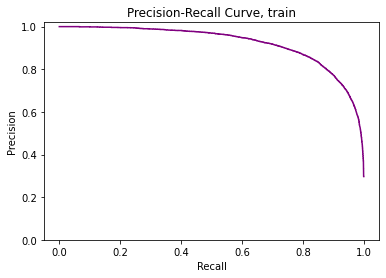

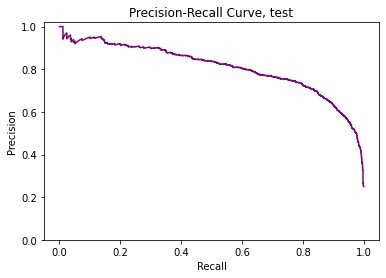

'Accuracy: '

0.9195786488402714

'F1 score: '

0.8406518423376416

'ROC score: '

0.8927890328909424

'Accuracy: '

0.8792851932895697

'F1 score: '

0.751687921980495

'ROC score: '

0.8354628736740598

Total time for the whole script:  1635.5557601451874 
 Time for the modeling part:  332.4522762298584


In [55]:
### Fit XGBoost using Optuna hyperparameter optimization ###

time1 = time.time()

def objective(trial, n_splits=2, n_jobs=-1, scale_pos_weight=1, early_stopping_rounds=50):

    cv_regularizer=0.0
    # Usually values between 0.1 and 0.2 work fine.

    params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 100, 800),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.01, 0.2),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.5, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 10.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 150.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
        "n_jobs": n_jobs,
    }

    X = X_train
    y = y_train

    model = XGBClassifier(**params)
    rkf = KFold(n_splits=n_splits, shuffle=True)
    X_values = X.values
    y_values = y.values
    y_pred = np.zeros_like(y_values)
    y_pred_train = np.zeros_like(y_values)
    for train_index, test_index in rkf.split(X_values):
        X_A, X_B = X_values[train_index, :], X_values[test_index, :]
        y_A, y_B = y_values[train_index], y_values[test_index]
        model.fit(X_A, y_A, eval_set=[(X_B, y_B)],
                  early_stopping_rounds=early_stopping_rounds, verbose = False)
        y_pred[test_index] += model.predict(X_B)
        y_pred_train[train_index] += model.predict(X_A)
    score_train = roc_auc_score(y_train, y_pred_train)
    score_test = roc_auc_score(y_train, y_pred) 
    overfit = score_train-score_test
    #return (f1_score_test)
    return (score_test-cv_regularizer*overfit)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)
print('Total time for hypermarameter optimization ', time.time()-time1)
hp = study.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")

optuna_hyperpars = study.best_params
optuna_hyperpars['tree_method']='gpu_hist'
optuna_hyperpars['scale_pos_weight']=1
#optuna_hyperpars['early_stopping_rounds']=50

optuna_xgb = XGBClassifier(**optuna_hyperpars)
optuna_xgb.fit(X_train, y_train)

y_score = optuna_xgb.predict_proba(X_test)[:, 1]

# pr in train set
precision_t, recall_t, threshold = precision_recall_curve(y_train, optuna_xgb.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]

fig, ax = plt.subplots()
ax.plot(recall_t, precision_t, color='purple')
ax.set_title('Precision-Recall Curve, train')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()

# pr in test set
precision, recall, threshold = precision_recall_curve(y_test, y_score)
auc_precision_recall_test = auc(recall, precision)
temp = recall[(recall>0.195)&(recall<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall==temp)))[0][0]
r20prec_test = precision[indexx]

fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')
ax.set_title('Precision-Recall Curve, test')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()


display('Accuracy: ', accuracy_score(y_train,optuna_xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,optuna_xgb.predict(X_train)))
display('ROC score: ', roc_auc_score(y_train,optuna_xgb.predict(X_train)))
#display('Recall score: ', recall_score(y_train,optuna_xgb.predict(X_train)))
#display('Precision score: ', precision_score(y_train,optuna_xgb.predict(X_train)))
#display('Precision at 20% recall: ', r20prec_train)
# Performance evaluation:
display('Accuracy: ', accuracy_score(y_test,optuna_xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,optuna_xgb.predict(X_test)))
display('ROC score: ', roc_auc_score(y_test,optuna_xgb.predict(X_test)))
#display('Recall score: ', recall_score(y_test,optuna_xgb.predict(X_test)))
#display('Precision score: ', precision_score(y_test,optuna_xgb.predict(X_test)))
#display('PRUC: ', auc_precision_recall_test)
#display('Precision at 20% recall: ', r20prec_test)

print('Total time for the whole script: ', time.time()-time0, '\n',
     'Time for the modeling part: ', time.time()-time1)

In [48]:
#submission_df_bt = pd.DataFrame({'Id': pred.Id, 'SalePrice': xgbm3.predict(X_pred[cols_veryveryfew])}, columns=['Id', 'SalePrice'])

#submission_df_bt.to_csv('KP20_bt.csv',index=False)

#os.chdir(r'/kaggle/working')

#from IPython.display import FileLink
#FileLink(r'KP20_bt.csv')

In [56]:
#df = pd.read_csv('../input/amex-default-prediction/train_data.csv', skiprows=lambda i: i>0 and random.random() > 0.2)
#display(df.shape)

#with open('KP15_downsampled02.pickle', 'wb') as f:
#    pickle.dump(df, f)


(1105326, 190)